In [2]:
import glob
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "../../../data/sb56/data/Imagenet/train/n07745940/"
images = glob.glob(data_dir + "*.JPEG")
print(len(images))
print(images)

1300
['../../../data/sb56/data/Imagenet/train/n07745940/n07745940_8923.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_17650.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_2244.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_10884.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_11954.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_2044.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_13239.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_9485.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_1218.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_12570.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_10788.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_6142.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n07745940_2103.JPEG', '../../../data/sb56/data/Imagenet/train/n07745940/n0

In [4]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])
    
def merge_segments(img, segmentation_mask, num_segments_desired):
    num_segs = len(np.unique(segmentation_mask))

    # Merge nodes while loop
    while num_segs > num_segments_desired:

        # Create RAG
        g = skimage.graph.rag_mean_color(img, segmentation_mask)
        print(g)
        
        # Initialize
        num_edges = g.number_of_edges()
        weights_list = [None] * num_edges

        # Iterate and determine threshold weight for merging
        i = 0
        for edge in g.edges:
            # Get the weight of the edge
            weight = g[edge[0]][edge[1]]['weight']
            
            # print(f'Edge: {edge}, Weight: {weight}')
            weights_list[i] = weight
            i += 1

        weights_list.sort()
        # print(weights_list)

        reduce_num = num_segs - num_segments_desired
        reduce_num = 1 if reduce_num <= 0 else reduce_num # After certain amount, only remove 1 by 1
        threshold = weights_list[reduce_num]
        print(threshold)
        print(weights_list)

        # Merge based on threshold
        segmentation_mask = skimage.graph.merge_hierarchical(segmentation_mask, g, thresh=threshold, rag_copy=False,
                                        in_place_merge=True,
                                        merge_func=merge_mean_color,
                                        weight_func=_weight_mean_color)
        
        num_segs = len(np.unique(segmentation_mask))
        

    return segmentation_mask

In [5]:
# User variables
img_stop_index = 100
num_segments_desired = 196

for i in range(img_stop_index):
    # Load image and resize
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # Apply segmentation 
    # segmentation_mask = skimage.segmentation.felzenszwalb(img, scale=100, sigma=0.5, min_size=150)
    segmentation_mask = skimage.segmentation.slic(img, n_segments=225, start_label=0)
    start_segs = len(np.unique(segmentation_mask))

    # out_mask = merge_segments(img, segmentation_mask, num_segments_desired)
    # end_segs = len(np.unique(out_mask))

    # print(f"Starting segments: {start_segs} | Ending segments {end_segs}")
    print(f"Starting segments: {start_segs}")




Starting segments: 115
Starting segments: 182
Starting segments: 151
Starting segments: 157
Starting segments: 184
Starting segments: 202
Starting segments: 205
Starting segments: 168
Starting segments: 195
Starting segments: 201
Starting segments: 171
Starting segments: 180
Starting segments: 159
Starting segments: 177
Starting segments: 163
Starting segments: 179
Starting segments: 192
Starting segments: 144
Starting segments: 158
Starting segments: 191
Starting segments: 185
Starting segments: 109
Starting segments: 77
Starting segments: 178
Starting segments: 161
Starting segments: 143
Starting segments: 120
Starting segments: 151
Starting segments: 166
Starting segments: 177
Starting segments: 173
Starting segments: 184
Starting segments: 142
Starting segments: 162
Starting segments: 184
Starting segments: 146
Starting segments: 102
Starting segments: 160
Starting segments: 155
Starting segments: 207
Starting segments: 148
Starting segments: 159
Starting segments: 154
Starting seg

Text(0.5, 1.0, 'Initial segmentation')

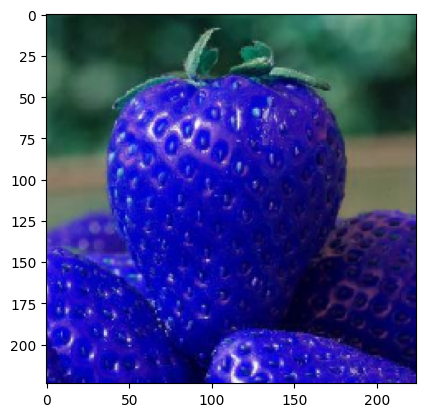

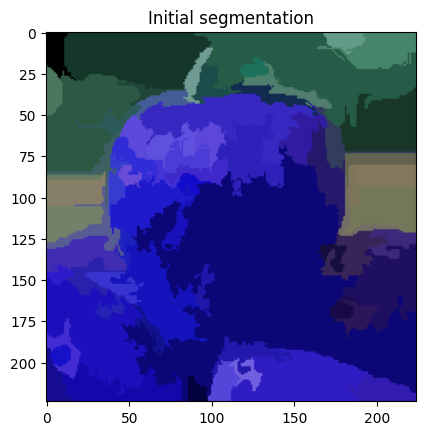

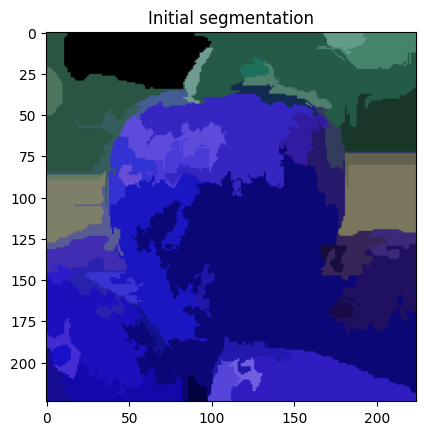

In [ ]:
plt.figure()
plt.imshow(img)

plt.figure()
out = skimage.color.label2rgb(segmentation_mask, img, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Initial segmentation')

plt.figure()
out = skimage.color.label2rgb(out_mask, img, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Initial segmentation')